In [1]:
# Standard library imports
import os
import datetime
import pickle
import time
from glob import glob
from typing import Dict, List, Optional, Set, Tuple

# Third party imports
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Local imports
from Utils.utils import visualize_bought, visualize_candidates
from Models.numerical_CBF import NumericalCBF
from Models.hybrid import HybridRecommender
from Models.collaborative_filtering import ALSRecommender, SVDRecommender

# Settings
os.environ['OPENBLAS_NUM_THREADS'] = '1' # Prevents OpenBLAS from using multiple threads
pd.set_option('display.max_columns', 500)

/opt/miniconda3/envs/eda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
customers = pd.read_pickle("Data/customers.pkl")
articles = pd.read_pickle("Data/articles.pkl")
transactions = pd.read_pickle("Data/transactions.pkl")

In [3]:
images = glob("Data/images/*/*", recursive=True)
image_ids = pd.DataFrame([{'image_id': image.split('/')[-1].split('.')[0], 'path': image} for image in images])

In [4]:
print("All Transactions Date Range: {} to {}".format(transactions['t_dat'].min(), transactions['t_dat'].max()))

transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

train = transactions.loc[(transactions["t_dat"] >= transactions["t_dat"].min()) & (transactions['t_dat'] < datetime.datetime(2020,9,16))]
val = transactions.loc[transactions["t_dat"] >= datetime.datetime(2020,9,16)]

All Transactions Date Range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


In [5]:
train_purchases = train.groupby('customer_id')['article_id'].agg(list).reset_index()
val_purchases = val.groupby('customer_id')['article_id'].agg(list).reset_index()

# Get users present in both sets
common_users = set(train_purchases['customer_id']) & set(val_purchases['customer_id'])

# Filter data for common users
train_filtered = train_purchases[train_purchases['customer_id'].isin(common_users)].reset_index(drop=True)
val_filtered = val_purchases[val_purchases['customer_id'].isin(common_users)].reset_index(drop=True)

In [6]:
articles.head(3)

,article_id,product_type_no,product_type_name,product_group_name,garment_group_no,garment_group_name,colour_group_code,colour_group_name,section_no,section_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,detail_desc
0,0108775015,253,Vest top,Garment Upper body,1002,Jersey Basic,9,Black,16,Womens Everyday Basics,4,Dark,5,Black,Jersey top with narrow shoulder straps.
1,0108775044,253,Vest top,Garment Upper body,1002,Jersey Basic,10,White,16,Womens Everyday Basics,3,Light,9,White,Jersey top with narrow shoulder straps.
2,0108775051,253,Vest top,Garment Upper body,1002,Jersey Basic,11,Off White,16,Womens Everyday Basics,1,Dusty Light,9,White,Jersey top with narrow shoulder straps.


In [ ]:
recommender = NumericalCBF(output_dir='recommendations', device='mps', batch_size=256)
recommender.fit(articles, train, customers)

In [7]:
recommender = HybridRecommender(
    alpha=0.5,
    als_params={
        'factors': 100,
        'regularization': 0.01,
        'alpha': 40,
        'iterations': 2
    },
    cbf_params={
        'batch_size': 256
    }
)

recommender.fit(train, customers, articles)

Fitting ALS model...


100%|██████████| 2/2 [00:28<00:00, 14.39s/it]


Fitting CBF model...
Fitting the model...
Pre-computing user purchase histories...


Building history lookup: 100%|██████████| 1356709/1356709 [00:50<00:00, 26616.25it/s]


Processing features...
Model fitted successfully!


In [ ]:
# If model weights are already saved, load them
if os.path.exists("Weights/als_recommender.pkl"):
    recommender = ALSRecommender.load("Weights/als_recommender.pkl")
else:
    recommender = ALSRecommender(
        factors=100,
        regularization=0.01,
        alpha=40,
        iterations=15,
        num_threads=8,
        use_gpu=False
    )
    
    recommender.fit(train, customers, articles)
    recommender.save("Weights/als_recommender.pkl")

In [ ]:
# If model weights are already saved, load them
if os.path.exists("Weights/svd_recommender.pkl"):
    recommender = SVDRecommender.load("Weights/svd_recommender.pkl")
else:
    recommender = SVDRecommender(
		factors=100,
	)
    
    recommender.fit(train, customers, articles)
    recommender.save("Weights/svd_recommender.pkl")

In [8]:
user_id = list(common_users)[1]
user_ids = list(common_users)

In [ ]:
candidates = recommender.batch_recommend_items(user_ids, n_items=100, filter_already_purchased=True)

In [9]:
candidates = recommender.recommend_items(user_id, n_items=100, filter_already_purchased=True)

In [10]:
candidates

[('0683662005', np.float64(0.5)),
 ('0780852004', np.float64(0.5)),
 ('0775311002', np.float64(0.49498945129886995)),
 ('0649437002', np.float64(0.49038703244402737)),
 ('0502186011', np.float64(0.33245073280919296)),
 ('0716348008', np.float64(0.3173748948334641)),
 ('0785018003', np.float64(0.31036899956944114)),
 ('0586896039', np.float64(0.30272629799313167)),
 ('0785018002', np.float64(0.2983214510047073)),
 ('0160442043', np.float64(0.26518799565831674)),
 ('0563519016', np.float64(0.2546484114877278)),
 ('0496111020', np.float64(0.24217314712924876)),
 ('0697992003', np.float64(0.2385932681272699)),
 ('0456163009', np.float64(0.2354667774949348)),
 ('0536139006', np.float64(0.23540760806511493)),
 ('0738943002', np.float64(0.23258958299739638)),
 ('0582480032', np.float64(0.23248618892252004)),
 ('0693243015', np.float64(0.22870980648008027)),
 ('0763280004', np.float64(0.22539507871213416)),
 ('0812167002', np.float64(0.2207714619008712)),
 ('0611415005', np.float64(0.214131644

In [11]:
candidates = pd.DataFrame(candidates, columns=['article_id', 'score'])
candidates = candidates.merge(articles, on='article_id', how='left')
candidates

,article_id,score,product_type_no,product_type_name,product_group_name,garment_group_no,garment_group_name,colour_group_code,colour_group_name,section_no,section_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,detail_desc,popularity_score,price
0,0683662005,0.500000,254,Top,Garment Upper body,1002,Jersey Basic,9,Black,51,Divided Basics,4,Dark,5,Black,Long-sleeved top in soft cotton jersey with ri...,9191,0.011944
1,0780852004,0.500000,272,Trousers,Garment Lower body,1005,Jersey Fancy,33,Dark Orange,15,Womens Everyday Collection,4,Dark,11,Beige,"Sleeveless playsuit in airy, patterned viscose...",1536,0.023652
2,0775311002,0.494989,253,Vest top,Garment Upper body,1005,Jersey Fancy,33,Dark Orange,15,Womens Everyday Collection,4,Dark,11,Beige,Body in soft viscose jersey with a wrapover V-...,1640,0.023358
3,0649437002,0.490387,297,Pyjama set,Nightwear,1017,"Under-, Nightwear",51,Light Pink,62,"Womens Nightwear, Socks & Tigh",1,Dusty Light,4,Pink,Pyjamas in a soft cotton blend. Long-sleeved t...,3676,0.032304
4,0502186011,0.332451,252,Sweater,Garment Upper body,1003,Knitwear,43,Dark Red,6,Womens Casual,4,Dark,18,Red,"Jumper in a soft, loose knit with low dropped ...",2206,0.030780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0599580017,0.063623,59,Swimwear bottom,Swimwear,1018,Swimwear,9,Black,60,"Womens Swimwear, beachwear",4,Dark,5,Black,Fully lined bikini bottoms with a mid waist an...,15229,0.016315
96,0777148003,0.062288,252,Sweater,Garment Upper body,1003,Knitwear,23,Dark Yellow,15,Womens Everyday Collection,2,Medium Dusty,13,Brown,"Slightly boxy jumper knitted in a soft, fluffy...",1637,0.039932
97,0673638001,0.062142,252,Sweater,Garment Upper body,1017,"Under-, Nightwear",9,Black,62,"Womens Nightwear, Socks & Tigh",4,Dark,5,Black,"Fine-knit, V-neck jumper with ribbing around t...",5864,0.015755
98,0610776065,0.059276,255,T-shirt,Garment Upper body,1002,Jersey Basic,21,Light Yellow,16,Womens Everyday Basics,3,Light,8,Yellow,T-shirt in lightweight jersey with a rounded h...,2631,0.008080


User's historical interactions:


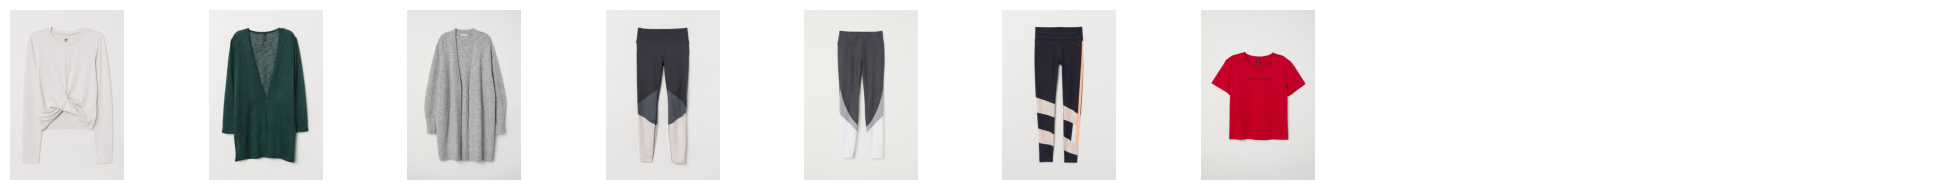

Val User's historical interactions:


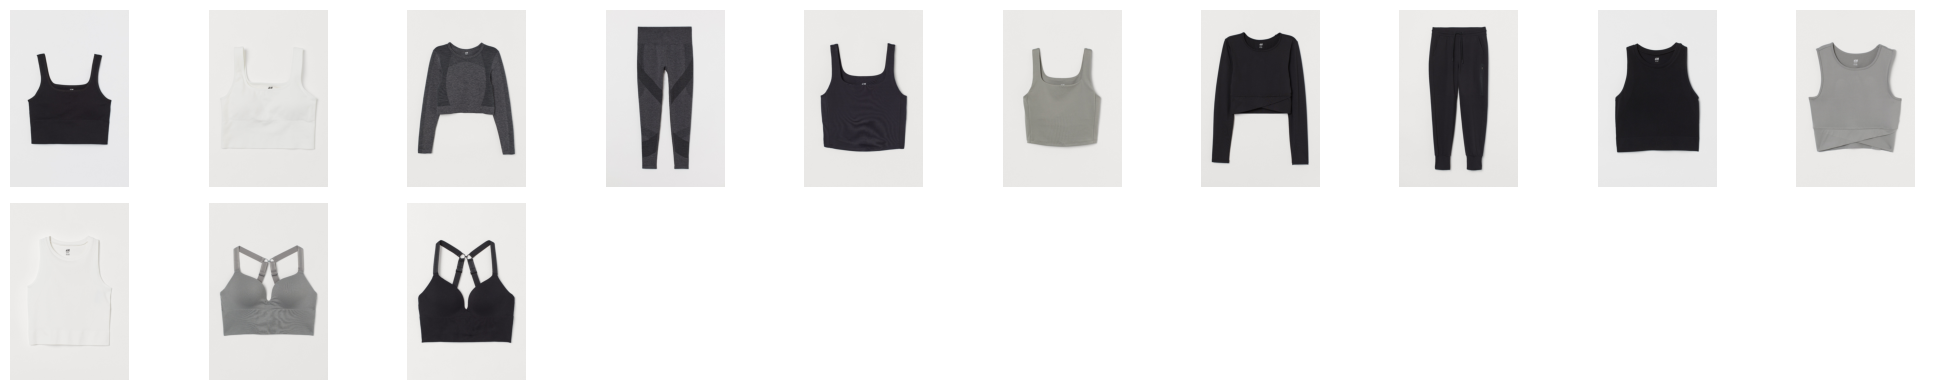

Candidates:


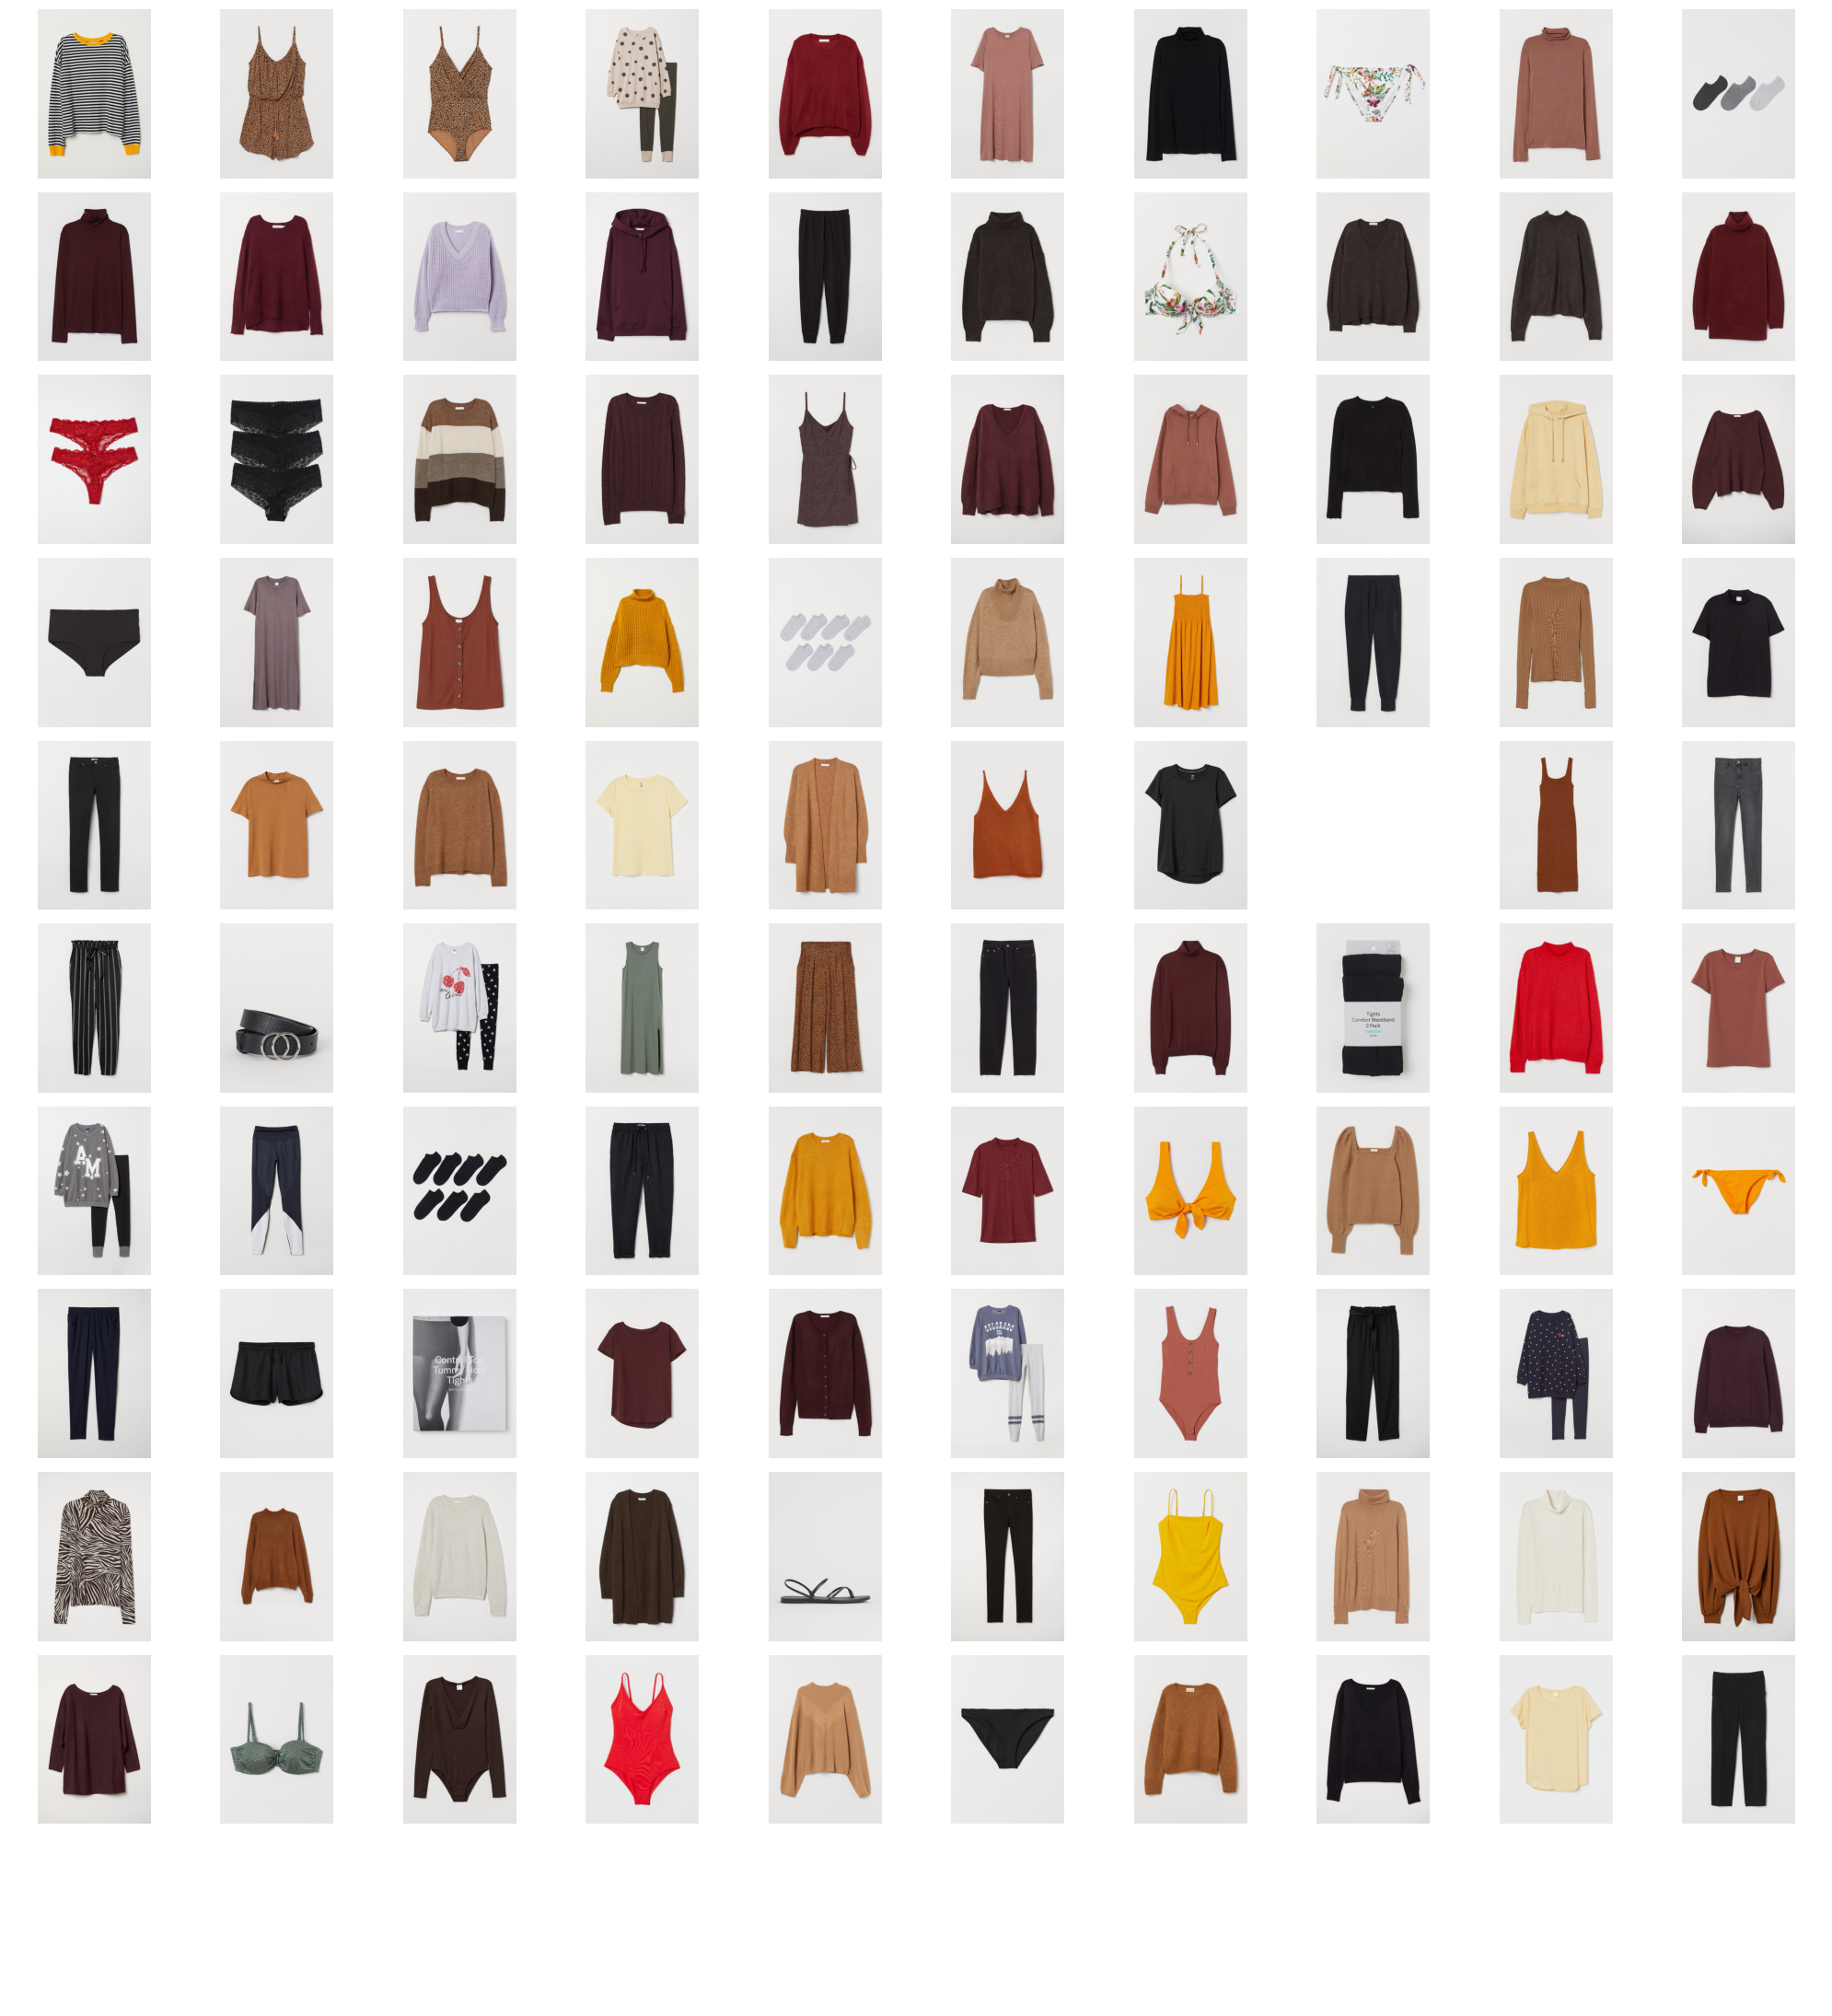

In [12]:
print("User's historical interactions:")
visualize_bought(user_id, train, image_ids)
print("Val User's historical interactions:")
visualize_bought(user_id, val, image_ids)
print("Candidates:")
visualize_candidates(candidates, image_ids)

In [13]:
import numpy as np
import time
from tqdm import tqdm

def calculate_recall_at_k(actual, predicted, k):
    """Calculate Recall@K for single user"""
    if len(actual) == 0:
        return 0.0
        
    # Only consider top k predictions
    predicted = predicted[:k]
    
    # Calculate intersection of actual and predicted
    num_hits = len(set(actual) & set(predicted))
    
    return num_hits / len(actual)

def calculate_coverage(all_candidates, catalog_items):
    """Calculate catalog coverage"""
    # Get unique items from all predictions
    predicted_items = set()
    for candidates in all_candidates:
        predicted_items.update(candidates)
        
    # Calculate coverage
    coverage = len(predicted_items) / len(catalog_items)
    
    return coverage

def calculate_diversity(all_candidates, item_features):
    """Calculate recommendation diversity"""
    if not item_features:
        return 0.0
        
    diversities = []
    
    for candidates in all_candidates:
        pair_diversities = []
        
        for i in range(len(candidates)):
            for j in range(i + 1, len(candidates)):
                item1, item2 = candidates[i], candidates[j]
                
                if item1 in item_features and item2 in item_features:
                    # Calculate cosine similarity
                    sim = np.dot(item_features[item1], item_features[item2])
                    sim /= (np.linalg.norm(item_features[item1]) * 
                           np.linalg.norm(item_features[item2]))
                    # Convert to diversity
                    pair_diversities.append(1 - sim)
                    
        if pair_diversities:
            diversities.append(np.mean(pair_diversities))
            
    return np.mean(diversities) if diversities else 0.0

def evaluate_model(
    model,
    users,
    items,
    purchases,
    k=10,
    item_features=None
):
    """
    Evaluate recommendation model
    
    Args:
        model: Recommendation model with recommend_items method
        users: List of user IDs
        items: Dictionary of item information
        purchases: Dictionary of user purchase history
        k: Number of recommendations to evaluate
        item_features: Optional dictionary of item features for diversity
    
    Returns:
        Dictionary of evaluation metrics
    """
    start = time.time()
    recalls = []
    all_candidates = []
    
    print("Evaluating model recommendations...")
    for user in tqdm(users):
        # Get user's purchases
        actual = purchases[user]
        
        # Get model's recommendations
        candidates = model.recommend_items(user, n_items=k)
        predicted = [c[0] for c in candidates]  # Assuming candidates are (item_id, score) tuples
        all_candidates.append(predicted)
        
        # Calculate Recall@K
        recall = calculate_recall_at_k(actual, predicted, k)
        recalls.append(recall)
    
    # Calculate metrics
    recall = np.mean(recalls)
    coverage = calculate_coverage(all_candidates, set(items.keys()))
    
    metrics = {
        f'Recall@{k}': recall,
        'Catalog Coverage': coverage,
    }
    
    # Add diversity if item features provided
    if item_features is not None:
        diversity = calculate_diversity(all_candidates, item_features)
        metrics['Diversity'] = diversity
    
    elapsed = time.time() - start
    metrics['Elapsed Time'] = elapsed
    
    print(f"Evaluated model in {elapsed:.2f} seconds")
    for metric, value in metrics.items():
        if metric != 'Elapsed Time':
            print(f"{metric}: {value:.4f}")
    
    return metrics

# Example usage:
model = recommender
users = list(common_users)
items = dict(articles['article_id'])
purchases = val_filtered.set_index('customer_id')['article_id'].to_dict()
item_features = None

metrics = evaluate_model(
    model=model,
    users=users,
    items=items,
    purchases=purchases,
    k=100,
    item_features=item_features
)


Evaluating model recommendations...


100%|██████████| 63412/63412 [02:59<00:00, 352.71it/s]


Evaluated model in 179.86 seconds
Recall@100: 0.0243
Catalog Coverage: 0.5511


In [14]:
metrics

{'Recall@100': np.float64(0.02427033420303707),
 'Catalog Coverage': 0.5510981410244263,
 'Elapsed Time': 179.85645961761475}